In [43]:
!pip install darts
!pip install xgboost

In [44]:
import numpy as np
import pandas as pd
from darts import TimeSeries
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
from darts.metrics import smape
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt

        waktu  DAIHATSU    HONDA  MITSUBISHI  SUZUKI   TOYOTA
0  2021-01-01    8993.0   7231.0      9108.0  6400.0  15474.0
1  2021-02-01    9412.0   6812.0      7567.0  4600.0  14645.0
2  2021-03-01   16770.0  11350.0     13088.0  8669.0  26034.0
3  2021-04-01   15861.0   8474.0     13820.0  8100.0  22618.0
4  2021-05-01    8310.0   5832.0     10160.0  5341.0  17361.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   waktu       54 non-null     object 
 1   DAIHATSU    54 non-null     float64
 2   HONDA       54 non-null     float64
 3   MITSUBISHI  54 non-null     float64
 4   SUZUKI      54 non-null     float64
 5   TOYOTA      54 non-null     float64
dtypes: float64(5), object(1)
memory usage: 2.7+ KB


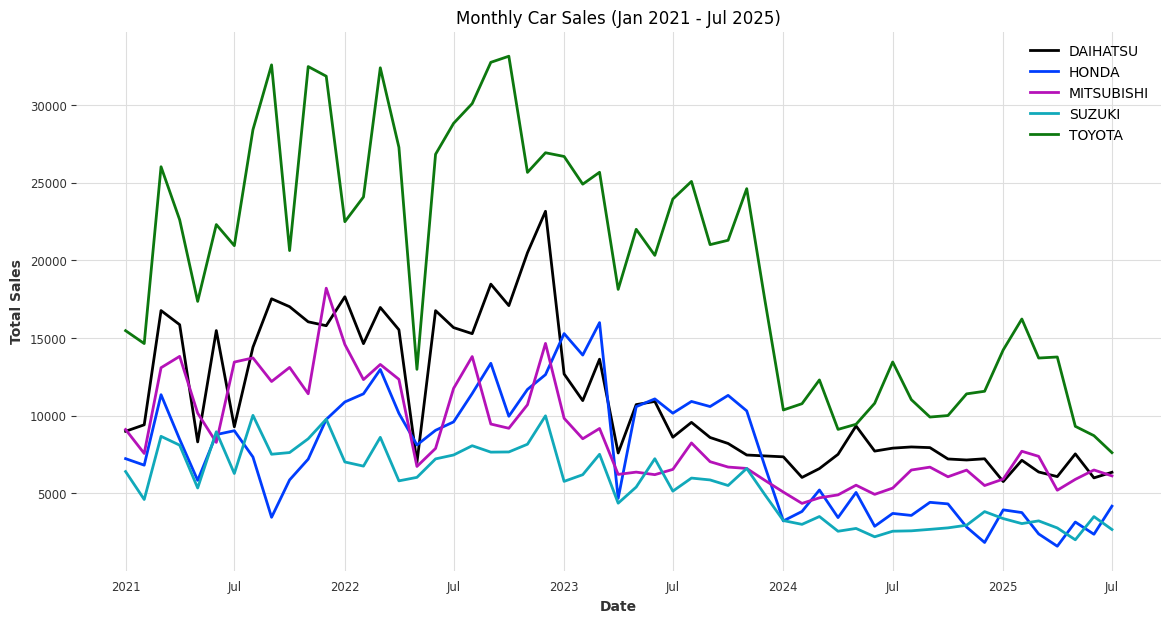

In [45]:
df = pd.read_csv("/kaggle/input/datacarsalegaikindo2021-2025/dataCarSale2021-2025.csv")
print(df.head())
df.info()

df['waktu'] = pd.to_datetime(df['waktu'])
df.set_index('waktu', inplace = True)

full_date = pd.date_range(start = df.index.min(), end = df.index.max(), freq="MS")
df = df.reindex(full_date)

df = df.interpolate(method = "linear")

series = TimeSeries.from_dataframe(df, freq='MS')

plt.figure(figsize=(14, 7))
series.plot()
plt.title('Monthly Car Sales (Jan 2021 - Jul 2025)')
plt.ylabel('Total Sales')
plt.xlabel('Date')
plt.grid(True)
plt.show()

In [46]:
df = df.reset_index().rename(columns={'index': 'waktu'})
df = df.melt(id_vars='waktu', var_name='Brand', value_name='Sales')

df['month'] = df['waktu'].dt.month
df['year'] = df['waktu'].dt.year
df['dayofweek'] = df['waktu'].dt.dayofweek
df['quarter'] = df['waktu'].dt.quarter
df['dayofyear'] = df['waktu'].dt.dayofyear

In [47]:
df = df.sort_values(by=['Brand', 'waktu'])

lags = [1, 2, 3, 6, 12]

for lag in lags:
    df[f'sales_lag_{lag}'] = df.groupby('Brand')['Sales'].shift(lag)

# print(df[df['Brand'] == 'TOYOTA'].tail())

In [48]:
window_sizes = [3, 6]

for window in window_sizes:
    df[f'sales_rolling_mean_{window}'] = df.groupby('Brand')['Sales'].rolling(window=window).mean().reset_index(level=0, drop=True)
    
    df[f'sales_rolling_std_{window}'] = df.groupby('Brand')['Sales'].rolling(window=window).std().reset_index(level=0, drop=True)

# print(df[df['Brand'] == 'TOYOTA'].tail())

In [49]:
try:
    df_ext = pd.read_csv("/kaggle/input/datacarsalegaikindo2021-2025/extFeat.csv")
    df_ext['waktu'] = pd.to_datetime(df_ext['waktu'])
    
    print("--- External features loaded successfully ---")
    print(df_ext.head())

    df_with_ext = pd.merge(df, df_ext, on='waktu', how='left')
    
    print(f"\nMissing values after merge: {df_with_ext.isnull().sum().sum()}")

    print("\n--- Merge Complete ---")
    print("Final DataFrame with all features (showing the new columns):")
    print(df_with_ext.tail())

except FileNotFoundError:
    print("File not found. Please ensure 'extFeat.csv' is uploaded to your Kaggle environment.")

df_final = df_with_ext.dropna()

--- External features loaded successfully ---
       waktu  bi_rate    IKK  harga_bensin  ritel_mom  inflasi_bulanan  \
0 2021-01-01     3.75   84.9          0.54       -4.3             0.26   
1 2021-02-01     3.50   85.8          0.54       -2.7             0.10   
2 2021-03-01     3.50   93.4          0.53        6.1             0.08   
3 2021-04-01     3.50  101.5          0.53       17.3             0.13   
4 2021-05-01     3.50  104.4          0.53        3.2             0.32   

   ritel_yoy  kredit_konsumen  belanja_konsumen  
0      -16.4             2.55              1.45  
1      -18.1             2.56              1.45  
2      -14.6             2.58              1.45  
3       15.6             2.60              1.47  
4       14.7             2.60              1.47  

Missing values after merge: 190

--- Merge Complete ---
Final DataFrame with all features (showing the new columns):
         waktu   Brand      Sales  month  year  dayofweek  quarter  dayofyear  \
270 2025-0

In [50]:
def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    epsilon = 1e-9
    return np.mean(numerator / (denominator + epsilon)) * 100

In [51]:
# FEATURES = [
#     'month', 'year', 'dayofweek', 'quarter', 'dayofyear',
#     'sales_lag_1', 'sales_lag_2', 'sales_lag_3', 'sales_lag_6', 'sales_lag_12',
#     'sales_rolling_mean_3', 'sales_rolling_std_3',
#     'sales_rolling_mean_6', 'sales_rolling_std_6',
#     'bi_rate', 'inflasi', 'IKK', 'inflasi_HK'
# ]
# TARGET = 'Sales'

# df_final['Brand'] = df_final['Brand'].astype('category')
# FEATURES.append('Brand')

# df_final = df_final.sort_values(by=['waktu', 'Brand'])

# X = df_final[FEATURES]
# y = df_final[TARGET]

# n_splits = 5
# tscv = TimeSeriesSplit(n_splits=n_splits)

# brand_scores = {brand: [] for brand in df_final['Brand'].unique()}
# overall_scores = []
# fold_number = 1

# for train_index, test_index in tscv.split(X):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#     model = lgb.LGBMRegressor(random_state=42)
#     model.fit(X_train, y_train)

#     predictions = model.predict(X_test)

#     results_df = pd.DataFrame({
#         'Brand': X_test['Brand'],
#         'Actuals': y_test,
#         'Predictions': predictions
#     })

#     for brand_name in results_df['Brand'].unique():
#         brand_df = results_df[results_df['Brand'] == brand_name]
#         brand_smape = smape(brand_df['Actuals'], brand_df['Predictions'])
#         brand_scores[brand_name].append(brand_smape)
#         print(f"  - SMAPE for {brand_name}: {brand_smape:.2f}%")

#     overall_fold_score = smape(results_df['Actuals'], results_df['Predictions'])
#     overall_scores.append(overall_fold_score)
#     print(f"  - Overall SMAPE for Fold {fold_number}: {overall_fold_score:.2f}%")
    
#     fold_number += 1
    
# for brand_name, scores in brand_scores.items():
#     print(f"Average SMAPE for {brand_name}: {np.mean(scores):.2f}%")

# print(f"\nOverall Average SMAPE across all folds: {np.mean(overall_scores):.2f}%")

In [52]:
# FEATURES = [
#     'month', 'year', 'dayofweek', 'quarter', 'dayofyear',
#     'sales_lag_1', 'sales_lag_2', 'sales_lag_3', 'sales_lag_6', 'sales_lag_12',
#     'sales_rolling_mean_3', 'sales_rolling_std_3',
#     'sales_rolling_mean_6', 'sales_rolling_std_6',
#     'bi_rate', 'inflasi', 'IKK', 'inflasi_HK'
# ]
# TARGET = 'Sales'

# df_encoded = pd.get_dummies(df_final, columns=['Brand'], drop_first=True)
# brand_columns = [col for col in df_encoded.columns if 'Brand_' in col]
# FEATURES.extend(brand_columns)


# df_encoded = df_encoded.sort_values(by=['waktu'])

# X = df_encoded[FEATURES]
# y = df_encoded[TARGET]

# n_splits = 5
# tscv = TimeSeriesSplit(n_splits=n_splits)

# overall_scores = []
# fold_number = 1

# for train_index, test_index in tscv.split(X):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)

#     model = Ridge(random_state=42)
#     model.fit(X_train_scaled, y_train)

#     predictions = model.predict(X_test_scaled)

#     overall_fold_score = smape(y_test, predictions)
#     overall_scores.append(overall_fold_score)
#     print(f"  - Overall SMAPE for Fold {fold_number}: {overall_fold_score:.2f}%")
    
#     fold_number += 1
  
# print(f"\nOverall Average SMAPE across all folds: {np.mean(overall_scores):.2f}%")

In [53]:
# from sklearn.neighbors import KNeighborsRegressor

# FEATURES = [
#     'month', 'year', 'dayofweek', 'quarter', 'dayofyear',
#     'sales_lag_1', 'sales_lag_2', 'sales_lag_3', 'sales_lag_12',
#     'sales_rolling_mean_3', 'sales_rolling_std_3',
#     'sales_rolling_mean_6', 'sales_rolling_std_6',
#     'bi_rate', 'IKK', 'inflasi_bulanan', 'ritel_yoy'
# ]
# TARGET = 'Sales'

# df_encoded = pd.get_dummies(df_final, columns=['Brand'], drop_first=True)

# brand_columns = [col for col in df_encoded.columns if 'Brand_' in col]
# FEATURES.extend(brand_columns)

# df_encoded = df_encoded.sort_values(by=['waktu'])

# X = df_encoded[FEATURES]
# y = df_encoded[TARGET]

# k_values = [3, 5, 7, 10, 15, 20] 
# k_performance = {}

# n_splits = 5
# tscv = TimeSeriesSplit(n_splits=n_splits)

# for k in k_values:
#     print(f"\nTesting with n_neighbors = {k}...")
#     overall_scores = []
#     fold_number = 1

#     for train_index, test_index in tscv.split(X):
#         X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#         y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
#         scaler = StandardScaler()
#         X_train_scaled = scaler.fit_transform(X_train)
#         X_test_scaled = scaler.transform(X_test)
    
#         model = KNeighborsRegressor(n_neighbors=k)
#         model.fit(X_train_scaled, y_train)
    
#         predictions = model.predict(X_test_scaled)
    
#         overall_fold_score = smape(y_test, predictions)
#         overall_scores.append(overall_fold_score)
        
#         print(f"--- Fold {fold_number}: Overall SMAPE = {overall_fold_score:.2f}% ---")
#         fold_number += 1

#     average_score = np.mean(overall_scores)
#     k_performance[k] = average_score
#     print(f"  -> Average SMAPE: {average_score:.2f}%")

# best_k = min(k_performance, key=k_performance.get)
# best_score = k_performance[best_k]

# print(f"Best k: {best_k} with an Average SMAPE of {best_score:.2f}%")

In [54]:
# from darts import TimeSeries
# from darts.models import TransformerModel
# from darts.dataprocessing.transformers import Scaler
# from darts.metrics import smape

# df_final = df_final.sort_values(by=['waktu', 'Brand'])

# df_target = df_final.pivot(index='waktu', columns='Brand', values='Sales')
# target_series = TimeSeries.from_dataframe(df_target, freq='MS')

# all_covariates = []
# FEATURES = [
#     'month', 'year', 'dayofweek', 'quarter', 'dayofyear',
#     'sales_lag_1', 'sales_lag_2', 'sales_lag_3', 'sales_lag_12',
#     'sales_rolling_mean_3', 'sales_rolling_std_3',
#     'sales_rolling_mean_6', 'sales_rolling_std_6',
#     'bi_rate', 'IKK', 'inflasi_bulanan', 'ritel_yoy',
#     'kredit_konsumen'
# ]

# for brand in df_final['Brand'].unique():
#     brand_df = df_final[df_final['Brand'] == brand].set_index('waktu')
#     covariates_part = TimeSeries.from_dataframe(brand_df[FEATURES], freq='MS')
#     all_covariates.append(covariates_part)

# covariate_series = all_covariates[0].stack(all_covariates[1])
# for i in range(2, len(all_covariates)):
#     covariate_series = covariate_series.stack(all_covariates[i])

# scaler_target = Scaler()
# scaler_covs = Scaler()
# target_scaled = scaler_target.fit_transform(target_series)
# covs_scaled = scaler_covs.fit_transform(covariate_series)

# model_transformer = TransformerModel(
#     input_chunk_length=24,
#     output_chunk_length=12,
#     n_epochs=100,
#     random_state=42,
# )

# backtest = model_transformer.historical_forecasts(
#     target_scaled,
#     past_covariates=covs_scaled,
#     start=0.6,
#     forecast_horizon=1,
#     stride=1,
#     verbose=True
# )

# backtest_unscaled = scaler_target.inverse_transform(backtest)

# smape_transformer = smape(target_series, backtest_unscaled)

# print(f"Overall Average SMAPE for Transformer Model: {smape_transformer:.2f}%")

# for i, brand in enumerate(target_series.components):
#     brand_smape = smape(target_series.univariate_component(i), backtest_unscaled.univariate_component(i))
#     print(f"  - {brand}: {brand_smape:.2f}%")

In [55]:
# from sklearn.neighbors import KNeighborsRegressor

# def our_smape(y_true, y_pred):
#     numerator = np.abs(y_pred - y_true)
#     denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
#     epsilon = 1e-9
#     return np.mean(numerator / (denominator + epsilon)) * 100

In [56]:
# FEATURES = [
#     'month', 'year', 'dayofweek', 'quarter', 'dayofyear',
#     'sales_lag_1', 'sales_lag_2', 'sales_lag_3', 'sales_lag_12',
#     'sales_rolling_mean_3', 'sales_rolling_std_3',
#     'sales_rolling_mean_6', 'sales_rolling_std_6',
#     'bi_rate', 'IKK', 'inflasi_bulanan', 'ritel_yoy',
#     'kredit_konsumen'
# ]
# TARGET = 'Sales'

# df_final = df_final.sort_values(by=['waktu', 'Brand'])

# sklearn_results = []

# n_splits = 5
# tscv = TimeSeriesSplit(n_splits=n_splits)

# for train_index, test_index in tscv.split(df_final):
#     train_fold, test_fold = df_final.iloc[train_index], df_final.iloc[test_index]

#     # LGBM Training
#     lgbm_features = FEATURES + ['Brand']
#     X_train_lgbm = train_fold[lgbm_features].copy()
#     y_train_lgbm = train_fold[TARGET]
#     X_test_lgbm = test_fold[lgbm_features].copy()
#     X_train_lgbm['Brand'] = X_train_lgbm['Brand'].astype('category')
#     X_test_lgbm['Brand'] = X_test_lgbm['Brand'].astype('category')
#     lgbm = lgb.LGBMRegressor(random_state=42, verbosity=-1)
#     lgbm.fit(X_train_lgbm, y_train_lgbm)
#     preds_lgbm = lgbm.predict(X_test_lgbm)

#     # Ridge Training
#     train_fold_encoded = pd.get_dummies(train_fold, columns=['Brand'], drop_first=True)
#     test_fold_encoded = pd.get_dummies(test_fold, columns=['Brand'], drop_first=True)
#     brand_cols = [col for col in train_fold_encoded.columns if 'Brand_' in col]
#     ridge_features = FEATURES + brand_cols
#     X_train_ridge = train_fold_encoded[ridge_features]
#     y_train_ridge = train_fold_encoded[TARGET]
#     X_test_ridge = test_fold_encoded[ridge_features]
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train_ridge)
#     X_test_scaled = scaler.transform(X_test_ridge)
#     ridge = Ridge(random_state=42)
#     ridge.fit(X_train_scaled, y_train_ridge)
#     preds_ridge = ridge.predict(X_test_scaled)
    
#     # Store results for this fold
#     fold_results = test_fold[['waktu', 'Brand', 'Sales']].copy()
#     fold_results['preds_lgbm'] = preds_lgbm
#     fold_results['preds_ridge'] = preds_ridge
#     sklearn_results.append(fold_results)

# df_sklearn_preds = pd.concat(sklearn_results)

# # Transformer
# df_target = df_final.pivot(index='waktu', columns='Brand', values='Sales')
# target_series = TimeSeries.from_dataframe(df_target, freq='MS')

# all_covariates = []
# for brand in df_final['Brand'].unique():
#     brand_df = df_final[df_final['Brand'] == brand].set_index('waktu')
#     covariates_part = TimeSeries.from_dataframe(brand_df[FEATURES], freq='MS')
#     all_covariates.append(covariates_part)
# covariate_series = all_covariates[0].stack(all_covariates[1])
# for i in range(2, len(all_covariates)):
#     covariate_series = covariate_series.stack(all_covariates[i])
    
# scaler_target = Scaler()
# scaler_covs = Scaler()
# target_scaled = scaler_target.fit_transform(target_series)
# covs_scaled = scaler_covs.fit_transform(covariate_series)

# model_transformer = TransformerModel(input_chunk_length=24, output_chunk_length=12, n_epochs=100, random_state=42)
# backtest = model_transformer.historical_forecasts(
#     target_scaled, past_covariates=covs_scaled, start=0.6,
#     forecast_horizon=1, stride=1, verbose=False
# )
# backtest_unscaled = scaler_target.inverse_transform(backtest)
# df_transformer_preds = backtest_unscaled.to_dataframe().melt(
#     ignore_index=False, var_name='Brand', value_name='preds_transformer'
# ).reset_index()

# df_all_preds = pd.merge(df_sklearn_preds, df_transformer_preds, on=['waktu', 'Brand'])

# df_all_preds['ensemble'] = (0.8 * df_all_preds['preds_ridge']) + \
#                            (0.1 * df_all_preds['preds_lgbm']) + \
#                            (0.1 * df_all_preds['preds_transformer'])

# print("\n\n--- Cross-Validation Complete: Final 3-Model Ensemble Scores ---")
# brand_scores = {}
# for brand_name in df_all_preds['Brand'].unique():
#     brand_df = df_all_preds[df_all_preds['Brand'] == brand_name]
#     brand_smape = our_smape(brand_df['Sales'], brand_df['ensemble'])
#     brand_scores[brand_name] = brand_smape
    
# for brand_name, score in brand_scores.items():
#     print(f"Average SMAPE for {brand_name}: {score:.2f}%")

# overall_smape = our_smape(df_all_preds['Sales'], df_all_preds['ensemble'])
# print(f"\nOverall Average SMAPE for 3-Model Ensemble: {overall_smape:.2f}%")

In [63]:
# import xgboost as xgb
# from sklearn.model_selection import TimeSeriesSplit
# import numpy as np
# import pandas as pd

# FEATURES = [
#     'month', 'year', 'dayofweek', 'quarter', 'dayofyear',
#     'sales_lag_1', 'sales_lag_2', 'sales_lag_3', 'sales_lag_12',
#     'sales_rolling_mean_3', 'sales_rolling_std_3',
#     'sales_rolling_mean_6', 'sales_rolling_std_6',
#     'bi_rate', 'IKK', 'inflasi_bulanan', 'ritel_yoy', 'kredit_konsumen',
# ]
# TARGET = 'Sales'

# df_final['Brand'] = df_final['Brand'].astype('category')
# FEATURES.append('Brand')

# df_final = df_final.sort_values(by=['waktu', 'Brand'])

# X = df_final[FEATURES]
# y = df_final[TARGET]

# n_splits = 5
# tscv = TimeSeriesSplit(n_splits=n_splits)

# brand_scores = {brand: [] for brand in df_final['Brand'].unique()}
# overall_scores = []
# fold_number = 1

# for train_index, test_index in tscv.split(X):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#     model = xgb.XGBRegressor(
#         random_state=42,
#         enable_categorical=True
#     )
#     model.fit(X_train, y_train)

#     predictions = model.predict(X_test)

#     results_df = pd.DataFrame({
#         'Brand': X_test['Brand'],
#         'Actuals': y_test,
#         'Predictions': predictions
#     })

#     print(f"\n--- Fold {fold_number} Results ---")
#     for brand_name in results_df['Brand'].unique():
#         brand_df = results_df[results_df['Brand'] == brand_name]
#         brand_smape = smape(brand_df['Actuals'], brand_df['Predictions'])
#         brand_scores[brand_name].append(brand_smape)
#         print(f"  - SMAPE for {brand_name}: {brand_smape:.2f}%")
    
#     overall_fold_score = smape(results_df['Actuals'], results_df['Predictions'])
#     overall_scores.append(overall_fold_score)
#     print(f"  - Overall SMAPE for Fold {fold_number}: {overall_fold_score:.2f}%")
    
#     fold_number += 1

# for brand_name, scores in brand_scores.items():
#     print(f"Average SMAPE for {brand_name}: {np.mean(scores):.2f}%")

# print(f"\nOverall Average SMAPE for XGBoost: {np.mean(overall_scores):.2f}%")


--- Fold 1 Results ---
  - SMAPE for DAIHATSU: 20.48%
  - SMAPE for HONDA: 15.97%
  - SMAPE for MITSUBISHI: 22.20%
  - SMAPE for SUZUKI: 9.55%
  - SMAPE for TOYOTA: 16.32%
  - Overall SMAPE for Fold 1: 16.90%

--- Fold 2 Results ---
  - SMAPE for DAIHATSU: 27.01%
  - SMAPE for HONDA: 20.40%
  - SMAPE for MITSUBISHI: 14.73%
  - SMAPE for SUZUKI: 25.88%
  - SMAPE for TOYOTA: 13.12%
  - Overall SMAPE for Fold 2: 20.23%

--- Fold 3 Results ---
  - SMAPE for DAIHATSU: 14.69%
  - SMAPE for HONDA: 44.17%
  - SMAPE for MITSUBISHI: 26.74%
  - SMAPE for SUZUKI: 58.47%
  - SMAPE for TOYOTA: 20.92%
  - Overall SMAPE for Fold 3: 33.00%

--- Fold 4 Results ---
  - SMAPE for DAIHATSU: 14.03%
  - SMAPE for HONDA: 24.54%
  - SMAPE for MITSUBISHI: 9.32%
  - SMAPE for SUZUKI: 38.73%
  - SMAPE for TOYOTA: 8.58%
  - Overall SMAPE for Fold 4: 19.04%

--- Fold 5 Results ---
  - SMAPE for DAIHATSU: 5.80%
  - SMAPE for HONDA: 33.35%
  - SMAPE for MITSUBISHI: 12.77%
  - SMAPE for SUZUKI: 14.10%
  - SMAPE for T

/tmp/ipykernel_36/190657759.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_lgbm['Brand'] = X_test_lgbm['Brand'].astype('category')


  - SMAPE for DAIHATSU: 15.34%
  - SMAPE for HONDA: 15.05%
  - SMAPE for MITSUBISHI: 14.34%
  - SMAPE for SUZUKI: 11.40%
  - SMAPE for TOYOTA: 11.48%
  - Overall SMAPE for Fold 1: 13.52%


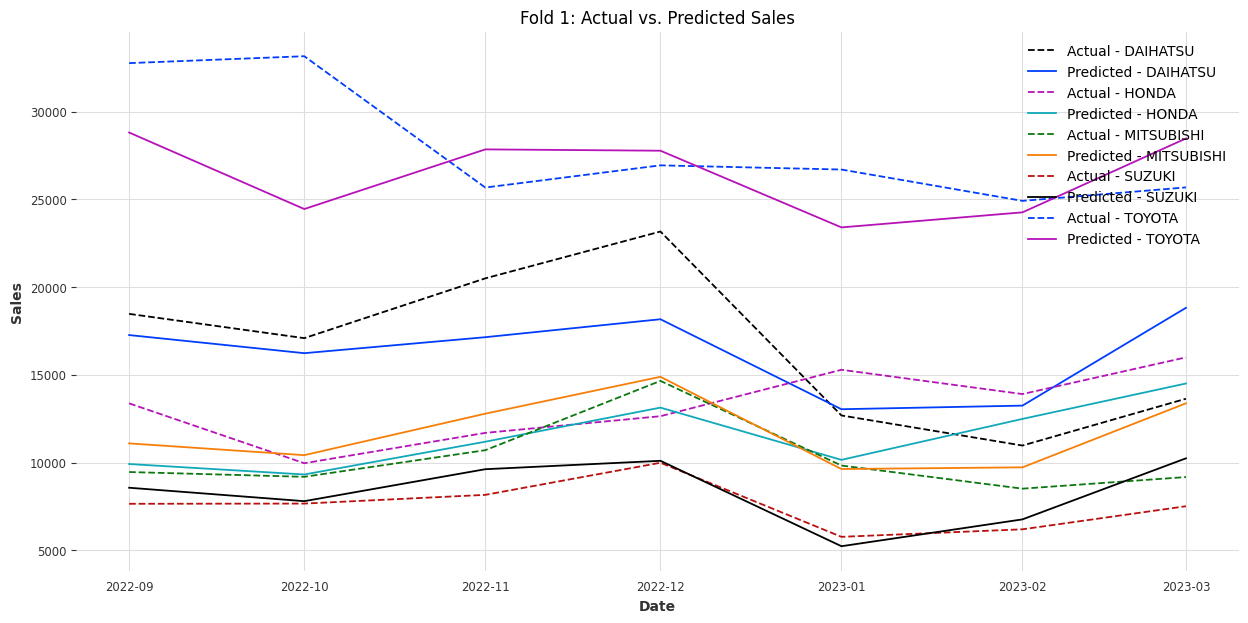

/tmp/ipykernel_36/190657759.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_lgbm['Brand'] = X_test_lgbm['Brand'].astype('category')


  - SMAPE for DAIHATSU: 20.15%
  - SMAPE for HONDA: 16.72%
  - SMAPE for MITSUBISHI: 11.54%
  - SMAPE for SUZUKI: 7.01%
  - SMAPE for TOYOTA: 7.94%
  - Overall SMAPE for Fold 2: 12.67%


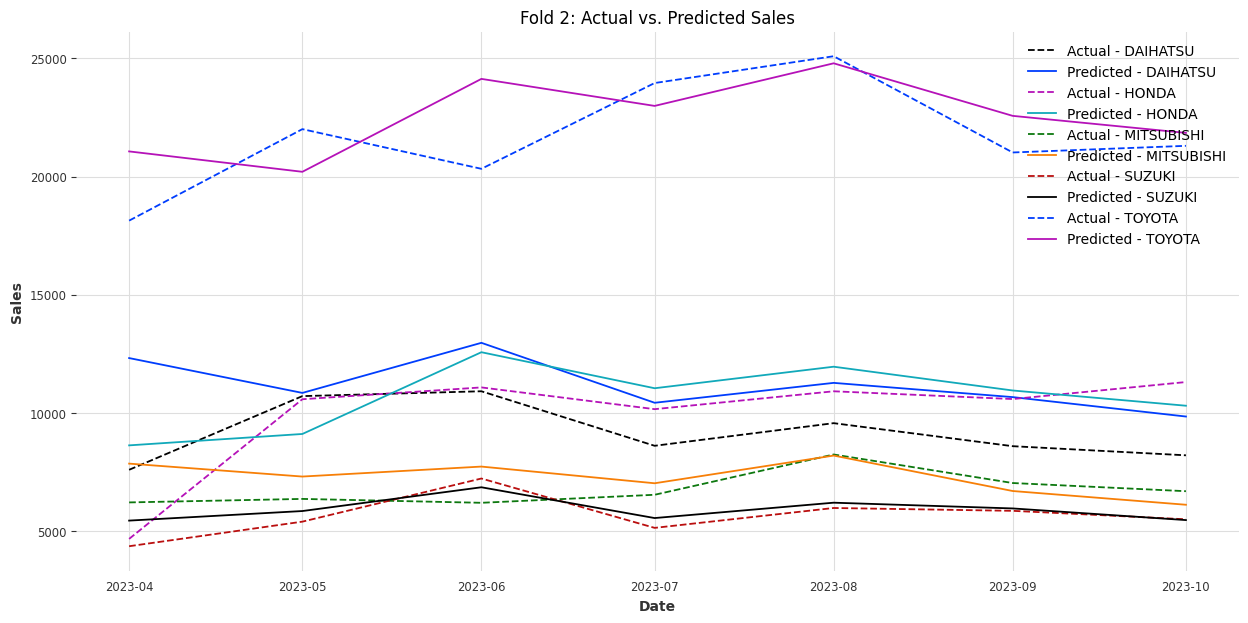

/tmp/ipykernel_36/190657759.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_lgbm['Brand'] = X_test_lgbm['Brand'].astype('category')


  - SMAPE for DAIHATSU: 12.48%
  - SMAPE for HONDA: 24.83%
  - SMAPE for MITSUBISHI: 7.14%
  - SMAPE for SUZUKI: 10.76%
  - SMAPE for TOYOTA: 22.04%
  - Overall SMAPE for Fold 3: 15.45%


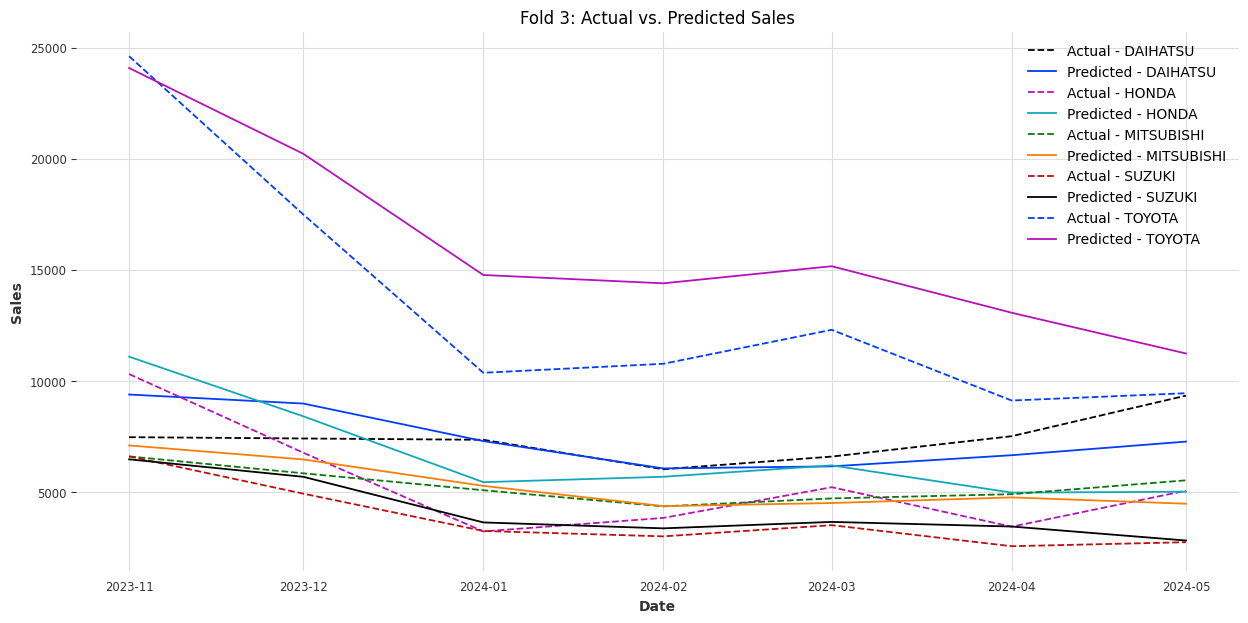

/tmp/ipykernel_36/190657759.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_lgbm['Brand'] = X_test_lgbm['Brand'].astype('category')


  - SMAPE for DAIHATSU: 5.71%
  - SMAPE for HONDA: 14.74%
  - SMAPE for MITSUBISHI: 13.28%
  - SMAPE for SUZUKI: 10.90%
  - SMAPE for TOYOTA: 5.45%
  - Overall SMAPE for Fold 4: 10.02%


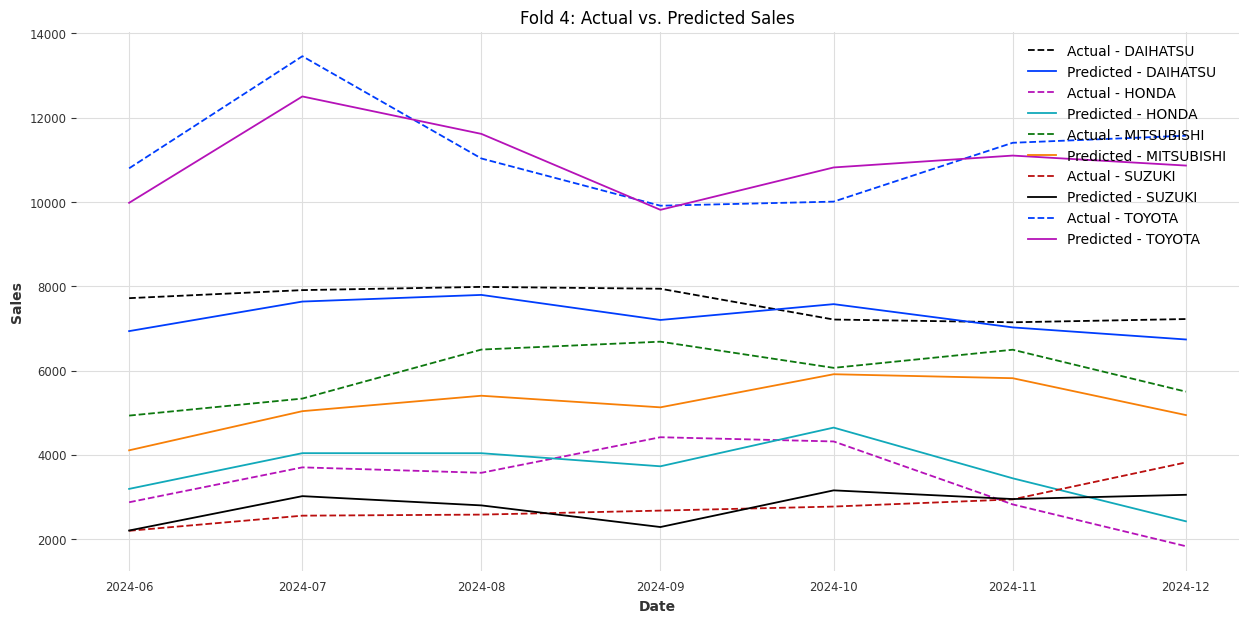

/tmp/ipykernel_36/190657759.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_lgbm['Brand'] = X_test_lgbm['Brand'].astype('category')


  - SMAPE for DAIHATSU: 5.31%
  - SMAPE for HONDA: 18.12%
  - SMAPE for MITSUBISHI: 11.35%
  - SMAPE for SUZUKI: 17.62%
  - SMAPE for TOYOTA: 11.76%
  - Overall SMAPE for Fold 5: 12.83%


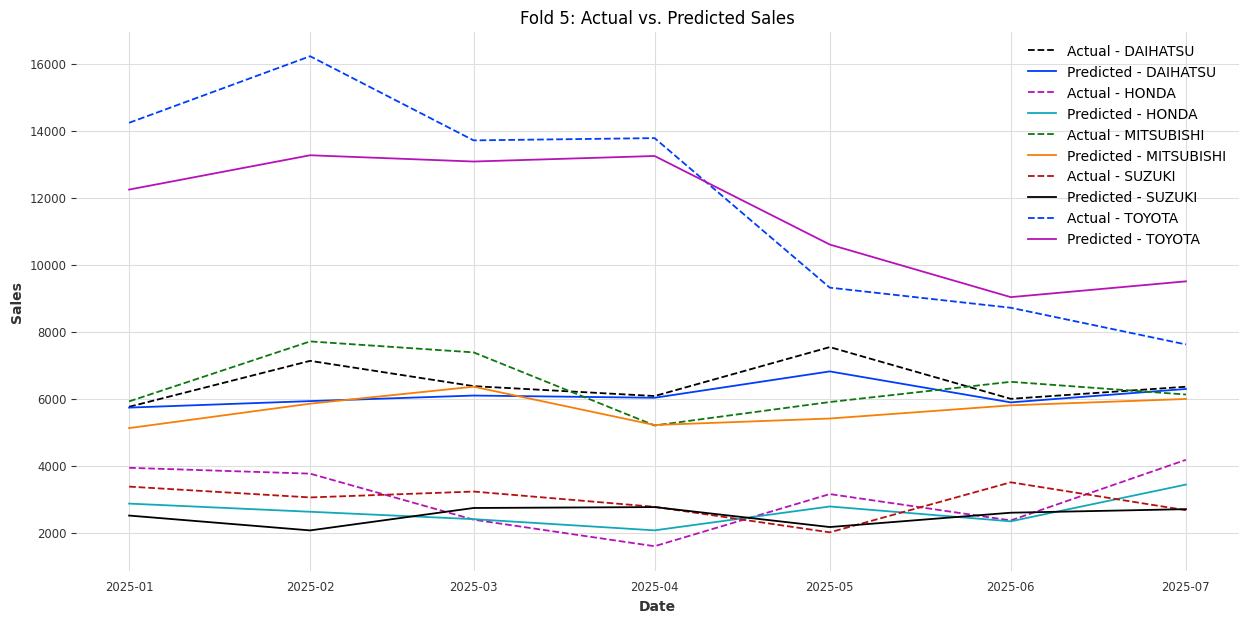

Average SMAPE for DAIHATSU: 11.80%
Average SMAPE for HONDA: 17.89%
Average SMAPE for MITSUBISHI: 11.53%
Average SMAPE for SUZUKI: 11.54%
Average SMAPE for TOYOTA: 11.74%

Overall Average SMAPE for Ensemble Model: 12.90%


In [59]:
FEATURES = [
    'month', 'year', 'dayofweek', 'quarter', 'dayofyear',
    'sales_lag_1', 'sales_lag_2', 'sales_lag_3', 'sales_lag_12',
    'sales_rolling_mean_3', 'sales_rolling_std_3',
    'sales_rolling_mean_6', 'sales_rolling_std_6',
    'bi_rate', 'IKK', 'inflasi_bulanan', 'ritel_yoy', 'kredit_konsumen',
]
TARGET = 'Sales'

df_final = df_final.sort_values(by=['waktu', 'Brand'])

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

brand_scores = {brand: [] for brand in df_final['Brand'].unique()}
overall_scores = []
fold_number = 1

for train_index, test_index in tscv.split(df_final):
    train_fold = df_final.iloc[train_index]
    test_fold = df_final.iloc[test_index]

    #LightGBM
    lgbm_features = FEATURES + ['Brand']
    X_train_lgbm = train_fold[lgbm_features].copy()
    y_train_lgbm = train_fold[TARGET].copy()
    X_test_lgbm = test_fold[lgbm_features]
    
    X_train_lgbm['Brand'] = X_train_lgbm['Brand'].astype('category')
    X_test_lgbm['Brand'] = X_test_lgbm['Brand'].astype('category')

    lgbm = lgb.LGBMRegressor(random_state=42, verbosity=-1)
    lgbm.fit(X_train_lgbm, y_train_lgbm)
    preds_lgbm = lgbm.predict(X_test_lgbm)

    # Ridge
    train_fold_encoded = pd.get_dummies(train_fold, columns=['Brand'], drop_first=True)
    test_fold_encoded = pd.get_dummies(test_fold, columns=['Brand'], drop_first=True)
    
    brand_cols = [col for col in train_fold_encoded.columns if 'Brand_' in col]
    ridge_features = FEATURES + brand_cols
    
    X_train_ridge = train_fold_encoded[ridge_features]
    y_train_ridge = train_fold_encoded[TARGET]
    X_test_ridge = test_fold_encoded[ridge_features]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_ridge)
    X_test_scaled = scaler.transform(X_test_ridge)

    ridge = Ridge(random_state=42)
    ridge.fit(X_train_scaled, y_train_ridge)
    preds_ridge = ridge.predict(X_test_scaled)

    #Ensemble
    ensemble_preds = 0.8 * preds_ridge + 0.2 * preds_lgbm

    #Evaluation
    results_df = pd.DataFrame({
        'waktu': test_fold['waktu'],
        'Brand': test_fold['Brand'],
        'Actuals': test_fold[TARGET],
        'Predictions': ensemble_preds
    })

    for brand_name in results_df['Brand'].unique():
        brand_df = results_df[results_df['Brand'] == brand_name]
        brand_smape = smape(brand_df['Actuals'], brand_df['Predictions'])
        brand_scores[brand_name].append(brand_smape)
        print(f"  - SMAPE for {brand_name}: {brand_smape:.2f}%")
    
    overall_fold_score = smape(results_df['Actuals'], results_df['Predictions'])
    overall_scores.append(overall_fold_score)
    print(f"  - Overall SMAPE for Fold {fold_number}: {overall_fold_score:.2f}%")

    #Visualization
    plt.figure(figsize=(15, 7))
    for brand in results_df['Brand'].unique():
        plot_df = results_df[results_df['Brand'] == brand]
        plt.plot(plot_df['waktu'], plot_df['Actuals'], '--', label=f'Actual - {brand}')
        plt.plot(plot_df['waktu'], plot_df['Predictions'], '-', label=f'Predicted - {brand}')
    
    plt.title(f'Fold {fold_number}: Actual vs. Predicted Sales')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    fold_number += 1

for brand_name, scores in brand_scores.items():
    print(f"Average SMAPE for {brand_name}: {np.mean(scores):.2f}%")

print(f"\nOverall Average SMAPE for Ensemble Model: {np.mean(overall_scores):.2f}%")

In [77]:
FEATURES = [
    'month', 'year', 'dayofweek', 'quarter', 'dayofyear',
    'sales_lag_1', 'sales_lag_2', 'sales_lag_3', 'sales_lag_12',
    'sales_rolling_mean_3', 'sales_rolling_std_3',
    'sales_rolling_mean_6', 'sales_rolling_std_6',
    'bi_rate', 'IKK', 'inflasi_bulanan', 'ritel_yoy', 'kredit_konsumen'
]
TARGET = 'Sales'

df_final['Brand'] = df_final['Brand'].astype('category')
df_final = df_final.sort_values(by=['waktu', 'Brand'])

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

brand_scores = {brand: [] for brand in df_final['Brand'].unique()}
overall_scores = []
fold_number = 1

for train_index, test_index in tscv.split(df_final):
    train_fold = df_final.iloc[train_index]
    test_fold = df_final.iloc[test_index]

    tree_features = FEATURES + ['Brand']
    X_train_tree = train_fold[tree_features].copy()
    y_train_tree = train_fold[TARGET]
    X_test_tree = test_fold[tree_features].copy()
    
    # LGBM
    lgbm = lgb.LGBMRegressor(random_state=42, verbosity=-1)
    lgbm.fit(X_train_tree, y_train_tree)
    preds_lgbm = lgbm.predict(X_test_tree)
    
    # XGBoost
    xgb_model = xgb.XGBRegressor(random_state=42, enable_categorical=True)
    xgb_model.fit(X_train_tree, y_train_tree)
    preds_xgb = xgb_model.predict(X_test_tree)

    # --- Train Ridge Model ---
    train_fold_encoded = pd.get_dummies(train_fold, columns=['Brand'], drop_first=True)
    test_fold_encoded = pd.get_dummies(test_fold, columns=['Brand'], drop_first=True)
    brand_cols = [col for col in train_fold_encoded.columns if 'Brand_' in col]
    ridge_features = FEATURES + brand_cols
    
    X_train_ridge = train_fold_encoded[ridge_features]
    y_train_ridge = train_fold_encoded[TARGET]
    X_test_ridge = test_fold_encoded[ridge_features]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_ridge)
    X_test_scaled = scaler.transform(X_test_ridge)

    ridge_model = Ridge(random_state=42)
    ridge_model.fit(X_train_scaled, y_train_ridge)
    preds_ridge = ridge_model.predict(X_test_scaled)
    
    ensemble_preds = (0.8 * preds_ridge) + (0.1 * preds_xgb) + (0.1 * preds_lgbm)

    results_df = pd.DataFrame({
        'Brand': test_fold['Brand'],
        'Actuals': test_fold[TARGET],
        'Predictions': ensemble_preds
    })

    print(f"\n--- Fold {fold_number} Results ---")
    for brand_name in results_df['Brand'].unique():
        brand_df = results_df[results_df['Brand'] == brand_name]
        brand_smape = smape(brand_df['Actuals'], brand_df['Predictions'])
        brand_scores[brand_name].append(brand_smape)
        print(f"  - SMAPE for {brand_name}: {brand_smape:.2f}%")
    
    overall_fold_score = smape(results_df['Actuals'], results_df['Predictions'])
    overall_scores.append(overall_fold_score)
    print(f"  - Overall SMAPE for Fold {fold_number}: {overall_fold_score:.2f}%")
    
    fold_number += 1

for brand_name, scores in brand_scores.items():
    print(f"Average SMAPE for {brand_name}: {np.mean(scores):.2f}%")

print(f"\nOverall Average SMAPE for 3-Model Ensemble: {np.mean(overall_scores):.2f}%")


--- Fold 1 Results ---
  - SMAPE for DAIHATSU: 14.83%
  - SMAPE for HONDA: 16.78%
  - SMAPE for MITSUBISHI: 13.43%
  - SMAPE for SUZUKI: 10.24%
  - SMAPE for TOYOTA: 11.78%
  - Overall SMAPE for Fold 1: 13.41%

--- Fold 2 Results ---
  - SMAPE for DAIHATSU: 20.70%
  - SMAPE for HONDA: 17.07%
  - SMAPE for MITSUBISHI: 11.72%
  - SMAPE for SUZUKI: 6.73%
  - SMAPE for TOYOTA: 7.74%
  - Overall SMAPE for Fold 2: 12.79%

--- Fold 3 Results ---
  - SMAPE for DAIHATSU: 11.70%
  - SMAPE for HONDA: 25.70%
  - SMAPE for MITSUBISHI: 7.36%
  - SMAPE for SUZUKI: 10.37%
  - SMAPE for TOYOTA: 20.50%
  - Overall SMAPE for Fold 3: 15.13%

--- Fold 4 Results ---
  - SMAPE for DAIHATSU: 4.16%
  - SMAPE for HONDA: 12.73%
  - SMAPE for MITSUBISHI: 12.01%
  - SMAPE for SUZUKI: 10.12%
  - SMAPE for TOYOTA: 5.13%
  - Overall SMAPE for Fold 4: 8.83%

--- Fold 5 Results ---
  - SMAPE for DAIHATSU: 6.27%
  - SMAPE for HONDA: 18.87%
  - SMAPE for MITSUBISHI: 11.26%
  - SMAPE for SUZUKI: 18.97%
  - SMAPE for TOYO

In [76]:
from sklearn.linear_model import Lasso
FEATURES = [
    'month', 'year', 'dayofweek', 'quarter', 'dayofyear',
    'sales_lag_1', 'sales_lag_2', 'sales_lag_3', 'sales_lag_12',
    'sales_rolling_mean_3', 'sales_rolling_std_3',
    'sales_rolling_mean_6', 'sales_rolling_std_6',
    'bi_rate', 'IKK', 'inflasi_bulanan', 'ritel_yoy', 'kredit_konsumen'
]
TARGET = 'Sales'

df_encoded = pd.get_dummies(df_final, columns=['Brand'], drop_first=True)

brand_columns = [col for col in df_encoded.columns if 'Brand_' in col]
FEATURES.extend(brand_columns)

df_encoded = df_encoded.sort_values(by=['waktu'])

X = df_encoded[FEATURES]
y = df_encoded[TARGET]

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

overall_scores = []
fold_number = 1

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = Lasso(random_state=42, max_iter=2000)
    model.fit(X_train_scaled, y_train)

    predictions = model.predict(X_test_scaled)

    overall_fold_score = smape(y_test, predictions)
    overall_scores.append(overall_fold_score)
    
    print(f"--- Fold {fold_number}: Overall SMAPE = {overall_fold_score:.2f}% ---")
    fold_number += 1

print(f"Average Overall SMAPE for Lasso Regression: {np.mean(overall_scores):.2f}%")

--- Fold 1: Overall SMAPE = 0.27% ---
--- Fold 2: Overall SMAPE = 0.13% ---
--- Fold 3: Overall SMAPE = 0.19% ---
--- Fold 4: Overall SMAPE = 0.12% ---
--- Fold 5: Overall SMAPE = 0.22% ---
Average Overall SMAPE for Lasso Regression: 0.19%



--- Fold 1 Results ---
  - SMAPE for DAIHATSU: 0.24%
  - SMAPE for HONDA: 0.40%
  - SMAPE for MITSUBISHI: 0.14%
  - SMAPE for SUZUKI: 0.40%
  - SMAPE for TOYOTA: 0.19%
  - Overall SMAPE for Fold 1: 0.27%


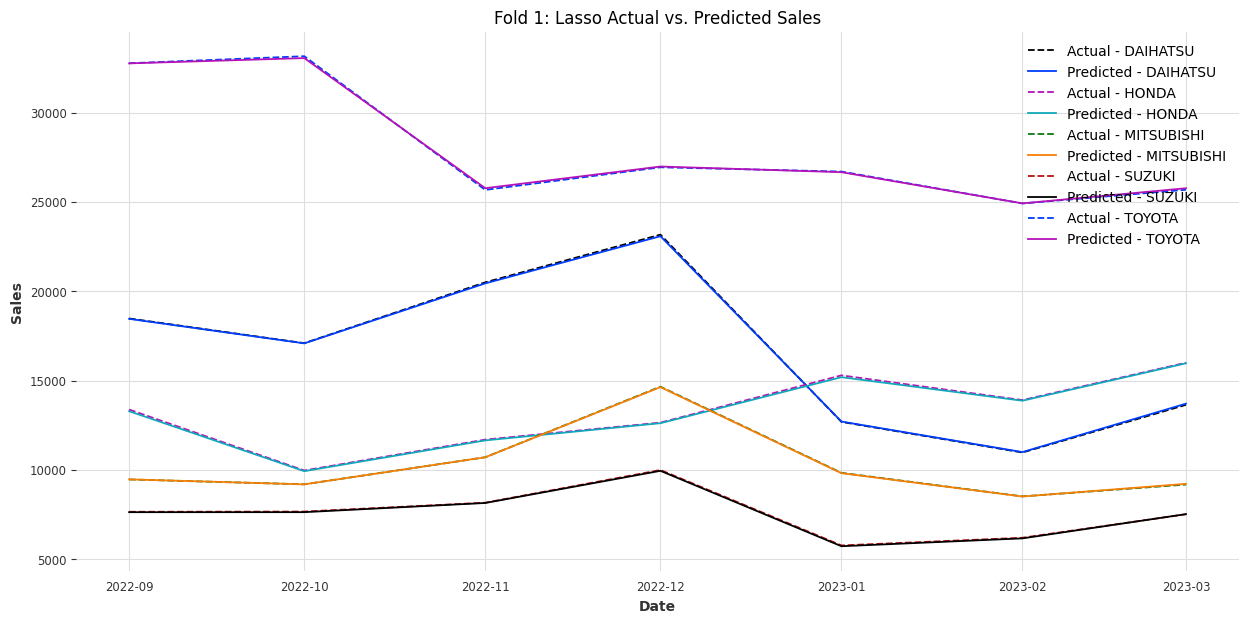


--- Fold 2 Results ---
  - SMAPE for DAIHATSU: 0.16%
  - SMAPE for HONDA: 0.23%
  - SMAPE for MITSUBISHI: 0.10%
  - SMAPE for SUZUKI: 0.09%
  - SMAPE for TOYOTA: 0.08%
  - Overall SMAPE for Fold 2: 0.13%


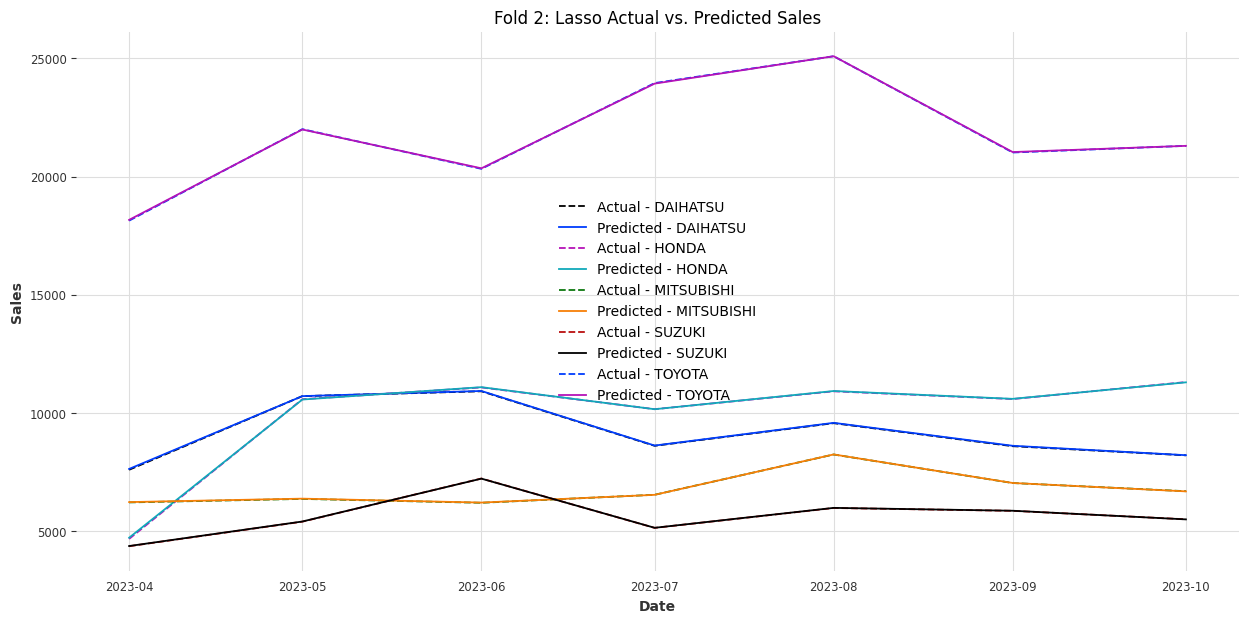


--- Fold 3 Results ---
  - SMAPE for DAIHATSU: 0.11%
  - SMAPE for HONDA: 0.31%
  - SMAPE for MITSUBISHI: 0.13%
  - SMAPE for SUZUKI: 0.20%
  - SMAPE for TOYOTA: 0.18%
  - Overall SMAPE for Fold 3: 0.19%


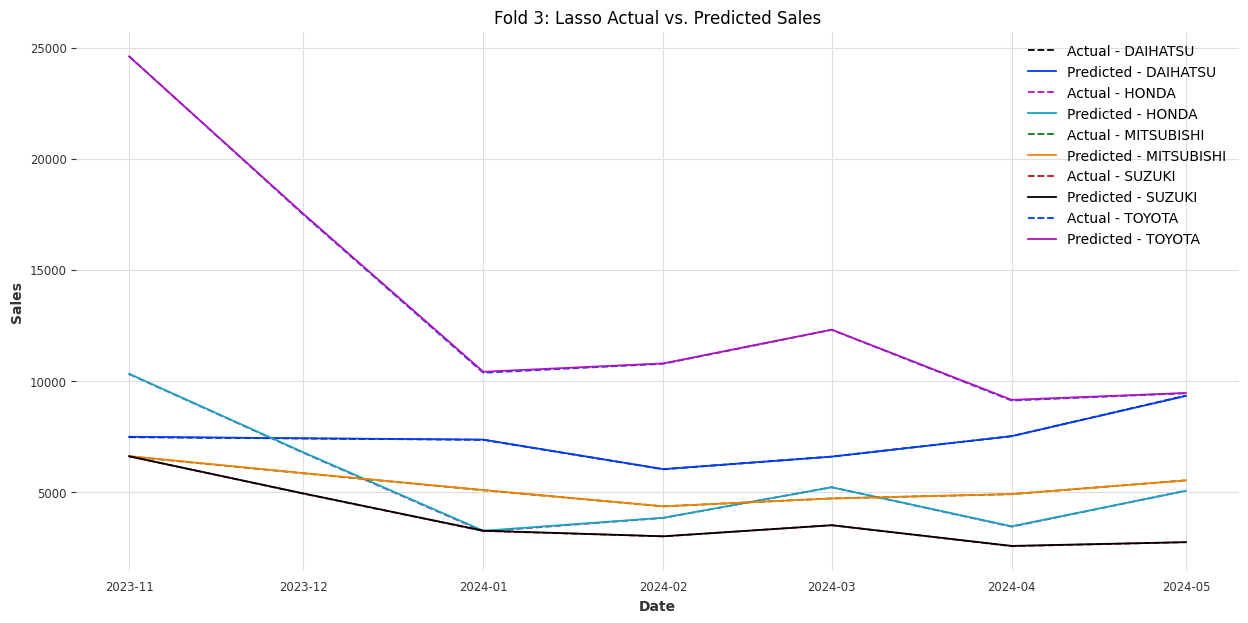


--- Fold 4 Results ---
  - SMAPE for DAIHATSU: 0.07%
  - SMAPE for HONDA: 0.09%
  - SMAPE for MITSUBISHI: 0.12%
  - SMAPE for SUZUKI: 0.22%
  - SMAPE for TOYOTA: 0.10%
  - Overall SMAPE for Fold 4: 0.12%


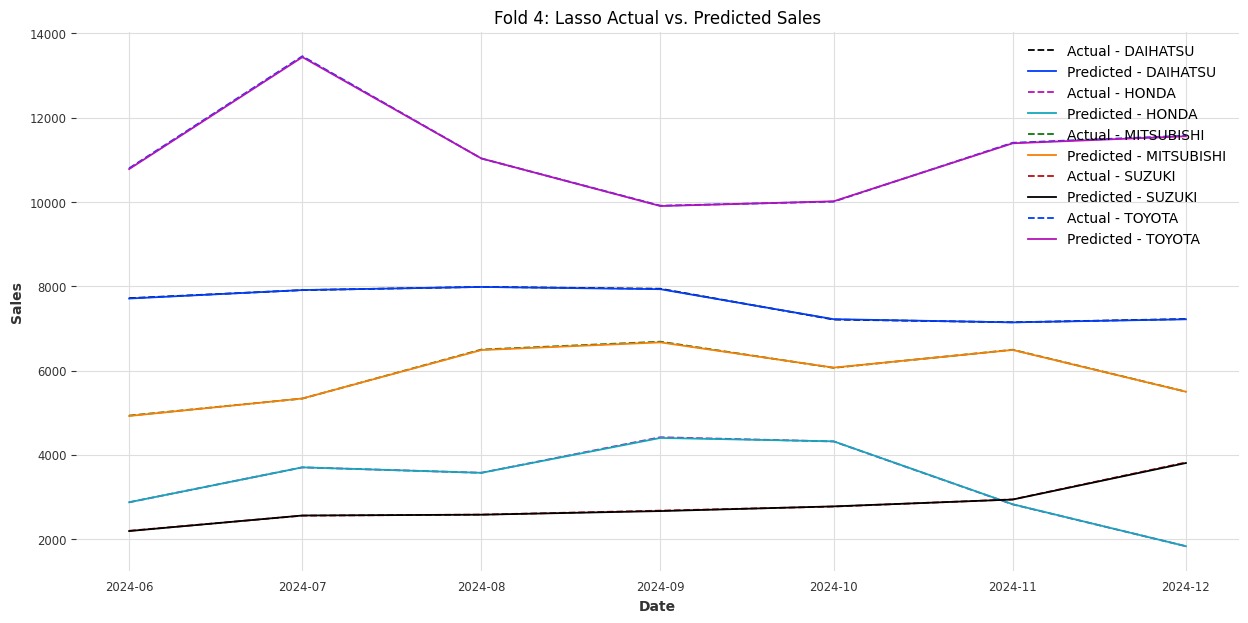


--- Fold 5 Results ---
  - SMAPE for DAIHATSU: 0.10%
  - SMAPE for HONDA: 0.37%
  - SMAPE for MITSUBISHI: 0.19%
  - SMAPE for SUZUKI: 0.26%
  - SMAPE for TOYOTA: 0.15%
  - Overall SMAPE for Fold 5: 0.22%


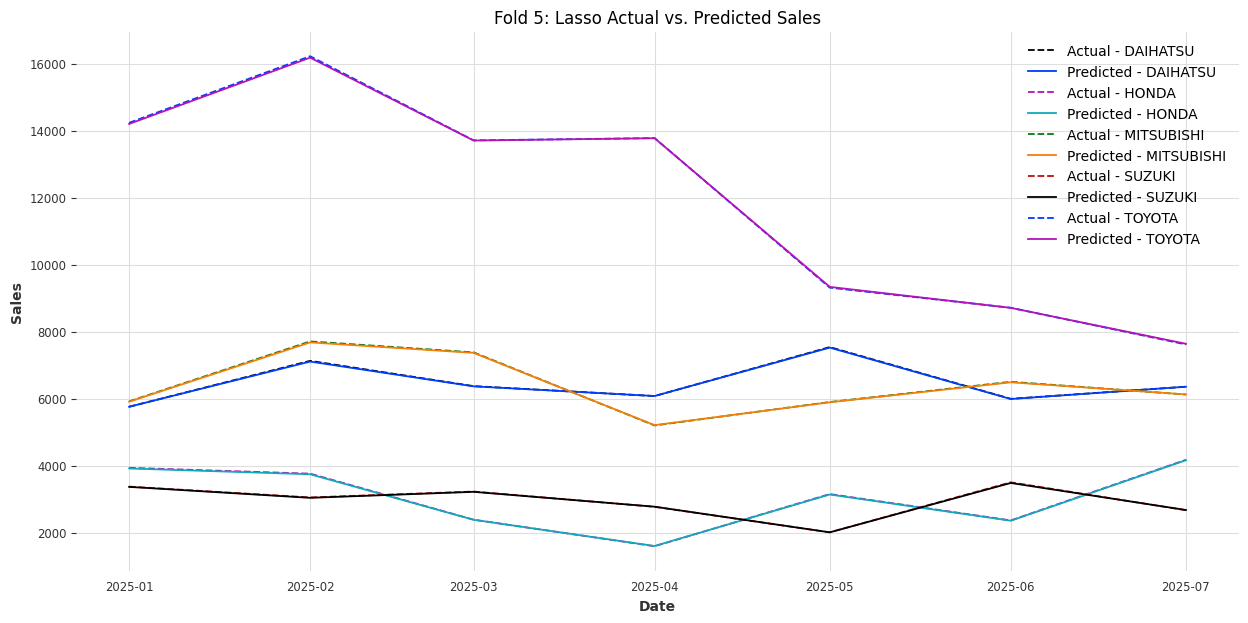

Average SMAPE for DAIHATSU: 0.14%
Average SMAPE for HONDA: 0.28%
Average SMAPE for MITSUBISHI: 0.14%
Average SMAPE for SUZUKI: 0.24%
Average SMAPE for TOYOTA: 0.14%


In [78]:
from sklearn.linear_model import Lasso

FEATURES = [
    'month', 'year', 'dayofweek', 'quarter', 'dayofyear',
    'sales_lag_1', 'sales_lag_2', 'sales_lag_3', 'sales_lag_12',
    'sales_rolling_mean_3', 'sales_rolling_std_3',
    'sales_rolling_mean_6', 'sales_rolling_std_6',
    'bi_rate', 'IKK', 'inflasi_bulanan', 'ritel_yoy', 'kredit_konsumen',
]
TARGET = 'Sales'

df_final = df_final.sort_values(by=['waktu', 'Brand'])

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

brand_scores = {brand: [] for brand in df_final['Brand'].unique()}
overall_scores = []
fold_number = 1

for train_index, test_index in tscv.split(df_final):
    train_fold = df_final.iloc[train_index]
    test_fold = df_final.iloc[test_index]

    train_fold_encoded = pd.get_dummies(train_fold, columns=['Brand'], drop_first=True)
    test_fold_encoded = pd.get_dummies(test_fold, columns=['Brand'], drop_first=True)
    brand_cols = [col for col in train_fold_encoded.columns if 'Brand_' in col]
    ridge_features = FEATURES + brand_cols
    
    X_train = train_fold_encoded[ridge_features]
    y_train = train_fold_encoded[TARGET]
    X_test = test_fold_encoded[ridge_features]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # --- Train Lasso Model ---
    model = Lasso(random_state=42, max_iter=2000)
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)

    # --- Evaluation ---
    results_df = pd.DataFrame({
        'waktu': test_fold['waktu'],
        'Brand': test_fold['Brand'],
        'Actuals': test_fold[TARGET],
        'Predictions': predictions
    })

    print(f"\n--- Fold {fold_number} Results ---")
    for brand_name in results_df['Brand'].unique():
        brand_df = results_df[results_df['Brand'] == brand_name]
        brand_smape = smape(brand_df['Actuals'], brand_df['Predictions'])
        brand_scores[brand_name].append(brand_smape)
        print(f"  - SMAPE for {brand_name}: {brand_smape:.2f}%")
    
    overall_fold_score = smape(results_df['Actuals'], results_df['Predictions'])
    overall_scores.append(overall_fold_score)
    print(f"  - Overall SMAPE for Fold {fold_number}: {overall_fold_score:.2f}%")
    
    # --- Visualization for this fold ---
    plt.figure(figsize=(15, 7))
    for brand in results_df['Brand'].unique():
        plot_df = results_df[results_df['Brand'] == brand]
        plt.plot(plot_df['waktu'], plot_df['Actuals'], '--', label=f'Actual - {brand}')
        plt.plot(plot_df['waktu'], plot_df['Predictions'], '-', label=f'Predicted - {brand}')
    
    plt.title(f'Fold {fold_number}: Lasso Actual vs. Predicted Sales')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    fold_number += 1

for brand_name, scores in brand_scores.items():
    print(f"Average SMAPE for {brand_name}: {np.mean(scores):.2f}%")